- Convolutions
  - Local operations on neighborhoods
  - Translation invariance
    - localized patterns have an effect on the output regardless of their location in the image
  - Models with fewer parameters

- Conv1d for time series
- Conv2d for images
- Conv3d for volumes of videos

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import collections

from torchvision import datasets
from torchvision import transforms

In [2]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [4]:
data_path = f"../Chapter 7/"

In [5]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [6]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [7]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

- PyTorch will slide the convolution kernel within the input picture, getting width - kernel_width + 1 horizontal and vertical positions.
- For odd-sized kernels, this results in images that are one-half the convolution kernel's width (3 / 2 = 1, in our case) smaller on each side.

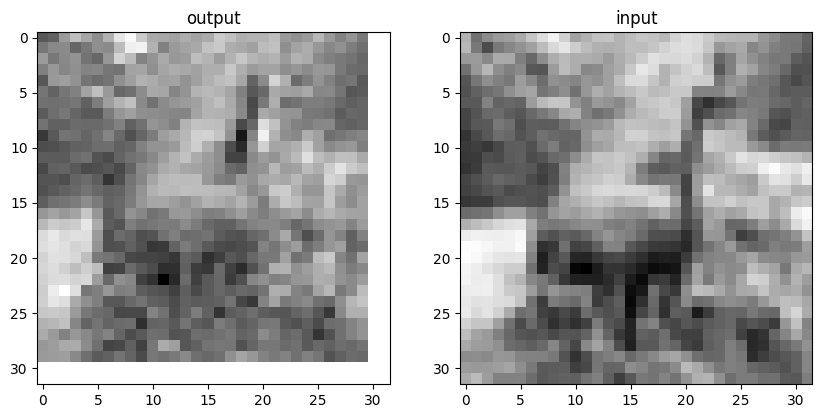

In [8]:
plt.figure(figsize=(10, 4.8))  
ax1 = plt.subplot(1, 2, 1)  
plt.title('output')  
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  
plt.imshow(img.mean(0), cmap='gray')  
plt.title('input')  
plt.show()

- Padding adds ghost pixels around the border that have value zero as far as the convolution is concerned
  - sizes of weight and bias don't change
  - helps us separate the matters of convolution and changing image sizes, so we have on less thing to remember
  - when we have more elaborate structures such as skip connections, we want the tensors before and after a few convolutions to be of compatible size so that we can add them or take differences

In [9]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [10]:
with torch.no_grad():
	conv.bias.zero_()

with torch.no_grad():
	conv.weight.fill_(1.0 / 9.0)

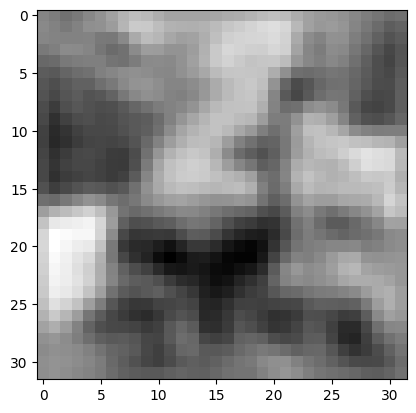

In [11]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [12]:
conv = nn.Conv2d(3, 1, kernel_size = 3, padding = 1)

with torch.no_grad():
	conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
									[-1.0, 0.0, 1.0],
									[-1.0, 0.0, 1.0]])
	conv.bias.zero_()

In [13]:
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

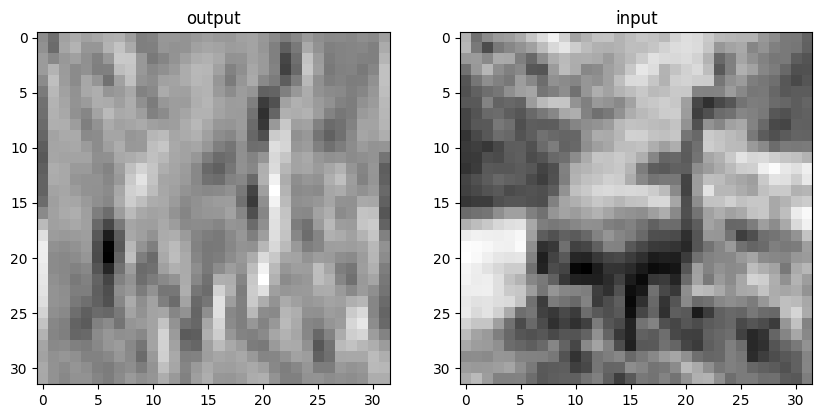

In [14]:
plt.figure(figsize=(10, 4.8))  
ax1 = plt.subplot(1, 2, 1)  
plt.title('output')  
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  
plt.imshow(img.mean(0), cmap='gray')  
plt.title('input')  
plt.show()

- Downsampling
  - Average the four pixels. The average pooling was a common approach early on but has fallen out of favor
  - Take the max of the four pixels. This approach, called max pooling, is currently the most commonly used approach, but it has a downside of discarding the other three-quarters of the data
  - Perform a strided convolution, where only every nth pixel is calculated. A 3x4 convolution with stride 2 still incorporates input from all pixels from the previous layer.  The literature shows promise for this approach, but has not yet supplanted max pooling

In [15]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [16]:
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
					nn.Tanh(),
					nn.MaxPool2d(2),
					nn.Conv2d(16, 8, kernel_size = 3, padding = 1),
			   		nn.Tanh(),
					nn.MaxPool2d(2),
					nn.Linear(8 * 8 * 8,  32),
					nn.Tanh(),
					nn.Linear(32, 2))

In [17]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [18]:
#model(img.unsqueeze(0))

In [19]:
class Net(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.act1 = nn.Tanh()
		self.pool1 = nn.MaxPool2d(2)
		self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
		self.act2 = nn.Tanh()
		self.pool2 = nn.MaxPool2d(2)
		self.fc1 = nn.Linear(8 * 8 * 8, 32)
		self.act3 = nn.Tanh()
		self.fc2 = nn.Linear(32, 2)
	
	def forward(self, x):
		out = self.pool1(self.act1(self.conv1(x)))
		out = self.pool2(self.act2(self.conv2(out)))
		out = out.view(-1, 8 * 8 * 8)
		out = self.act3(self.fc1(out))
		out = self.fc2(out)
		return out

In [20]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0779,  0.2978]], grad_fn=<AddmmBackward0>)

In [21]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [22]:
import torch.nn.functional as F

class Net(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
		self.fc1 = nn.Linear(8 * 8 * 8, 32)
		self.fc2 = nn.Linear(32, 2)

	def forward(self, x):
		out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
		out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
		out = out.view(-1, 8 * 8 * 8) 
		out = torch.tanh(self.fc1(out))
		out = self.fc2(out)
		return out

In [23]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1063, -0.0657]], grad_fn=<AddmmBackward0>)

In [24]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
	for epoch in range(1, n_epochs + 1):
		loss_train = 0.0
		# Loop over dataset in batches
		for imgs, labels in train_loader:
			# Feed batch through model
			outputs = model(imgs)
			# Compute the loss
			loss = loss_fn(outputs, labels)
			
			# Zero gradients from last iteration
			optimizer.zero_grad()
			# Compute gradients of all parameters we want the network to learn
			loss.backward()
			# Update the model
			optimizer.step()

			# Sum losses over the epoch
			loss_train += loss.item()
			
		if epoch == 1 or epoch % 10 == 0:
			print('{} Epoch {}, Training loss {}'.format(
			datetime.datetime.now(), epoch,
			loss_train / len(train_loader)))

In [25]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 100,
			  optimizer = optimizer,
			  model = model,
			  loss_fn = loss_fn,
			  train_loader = train_loader)

2023-10-19 13:02:44.909020 Epoch 1, Training loss 0.5772807558251035
2023-10-19 13:02:57.194177 Epoch 10, Training loss 0.3326728586937971
2023-10-19 13:03:11.207901 Epoch 20, Training loss 0.3018068358966499
2023-10-19 13:03:24.549016 Epoch 30, Training loss 0.2778434912869885
2023-10-19 13:03:37.784034 Epoch 40, Training loss 0.2568844796460905
2023-10-19 13:03:51.102127 Epoch 50, Training loss 0.2410406100617093
2023-10-19 13:04:04.336145 Epoch 60, Training loss 0.2278326819561849
2023-10-19 13:04:17.629216 Epoch 70, Training loss 0.21010922161257192
2023-10-19 13:04:30.842214 Epoch 80, Training loss 0.19687060992808858
2023-10-19 13:04:43.501709 Epoch 90, Training loss 0.18325998157167891
2023-10-19 13:04:56.033088 Epoch 100, Training loss 0.1661173696540723


In [26]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [27]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle = False)
all_acc_dict = collections.OrderedDict()

In [28]:
def validate(model, train_loader, val_loader):
	accdict = {}
	for name, loader in [("train", train_loader), ("val", val_loader)]:
		correct = 0
		total = 0

		# No longer want to update parameters
		with torch.no_grad():
			for imgs, labels in loader:
				imgs = imgs.to(device = device)
				labels = labels.to(device = device)

				outputs = model(imgs)
				_, predicted = torch.max(outputs, dim = 1)

				total += labels.shape[0]
				correct += int((predicted == labels).sum())
				
		print("Accuracy {}: {:.2f}".format(name , correct / total))
		accdict[name] = correct / total
	return accdict

In [29]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
	for epoch in range(1, n_epochs + 1):
		loss_train = 0.0
		# Loop over dataset in batches
		for imgs, labels in train_loader:
			imgs = imgs.to(device = device)
			labels = labels.to(device = device)
			# Feed batch through model
			outputs = model(imgs)
			# Compute the loss
			loss = loss_fn(outputs, labels)
			# Zero gradients from last iteration
			optimizer.zero_grad()
			# Compute gradients of all parameters we want the network to learn
			loss.backward()
			# Update the model
			optimizer.step()

			# Sum losses over the epoch
			loss_train += loss.item()
			
		if epoch == 1 or epoch % 10 == 0:
			print('{} Epoch {}, Training loss {}'.format(
			datetime.datetime.now(), epoch,
			loss_train / len(train_loader)))

In [30]:
model = Net().to(device = device)
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 100,
			  optimizer = optimizer,
			  model = model,
			  loss_fn = loss_fn,
			  train_loader = train_loader)

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

2023-10-19 13:05:01.872642 Epoch 1, Training loss 0.5791678738062549
2023-10-19 13:05:03.877462 Epoch 10, Training loss 0.332751341211568
2023-10-19 13:05:06.091472 Epoch 20, Training loss 0.3008852320112241
2023-10-19 13:05:08.249432 Epoch 30, Training loss 0.2783599314606114
2023-10-19 13:05:10.445427 Epoch 40, Training loss 0.25818902548331363
2023-10-19 13:05:12.630411 Epoch 50, Training loss 0.2413427627580181
2023-10-19 13:05:14.819398 Epoch 60, Training loss 0.2258197591183292
2023-10-19 13:05:17.011388 Epoch 70, Training loss 0.2107171927857551
2023-10-19 13:05:19.198374 Epoch 80, Training loss 0.19530996044350277
2023-10-19 13:05:21.386361 Epoch 90, Training loss 0.17962725408327807
2023-10-19 13:05:23.569344 Epoch 100, Training loss 0.16404439067574822
Accuracy train: 0.93
Accuracy val: 0.93


In [31]:
data_path = f"./"
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [32]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [33]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [34]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
	for epoch in range(1, n_epochs + 1):
		loss_train = 0.0
		
		for imgs, labels in train_loader:
			imgs = imgs.to(device = device)
			labels = labels.to(device = device)

			outputs = model(imgs)
			loss = loss_fn(outputs, labels)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			loss_train += loss.item()
		if epoch == 1 or epoch % 10 == 0:
			print('{} Epoch {}, Training loss {}'.format(
			datetime.datetime.now(), epoch,
			loss_train / len(train_loader)))


In [35]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 100,
				optimizer = optimizer,
				model = model,
				loss_fn = loss_fn,
				train_loader = train_loader)

2023-10-19 13:05:24.082581 Epoch 1, Training loss 0.611300383593626
2023-10-19 13:05:26.077392 Epoch 10, Training loss 0.33648267483255667
2023-10-19 13:05:28.272385 Epoch 20, Training loss 0.29817176814291885
2023-10-19 13:05:30.460373 Epoch 30, Training loss 0.2760255371878861
2023-10-19 13:05:32.715419 Epoch 40, Training loss 0.256168697147992
2023-10-19 13:05:34.945445 Epoch 50, Training loss 0.2383955110125481
2023-10-19 13:05:37.209501 Epoch 60, Training loss 0.22263368072023818
2023-10-19 13:05:39.411500 Epoch 70, Training loss 0.20840017540249856
2023-10-19 13:05:41.633518 Epoch 80, Training loss 0.1948134589726758
2023-10-19 13:05:43.855536 Epoch 90, Training loss 0.18145054816060766
2023-10-19 13:05:46.087563 Epoch 100, Training loss 0.16807711022389923


In [36]:
# PyTorch will attempt to load the weight on the same device it was saved from. Weights on the GPU will be restored to the GPU
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

- width
  - the number of neurons per layer, or channels per convolution
  - increase width by specifying a large number of output channels

In [37]:
class NetWidth(nn.Module):
	def __init__(self, n_chans1 = 32):
		super().__init__()
		self.n_chans1 = n_chans1
		self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3, padding = 1)
		self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size = 3, padding = 1)

		self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
		self.fc2 = nn.Linear(32, 2)
	
	def forward(self, x):
		out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
		out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
		out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
		out = torch.tanh(self.fc1(out))
		out = self.fc2(out)
		return out

In [38]:
model2 = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model2.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model2,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model2, train_loader, val_loader)

2023-10-19 13:05:46.415105 Epoch 1, Training loss 0.5448473249651065
2023-10-19 13:05:48.681163 Epoch 10, Training loss 0.3129549296988044
2023-10-19 13:05:51.143399 Epoch 20, Training loss 0.2758123473187161
2023-10-19 13:05:53.599629 Epoch 30, Training loss 0.2441333429828571
2023-10-19 13:05:56.087889 Epoch 40, Training loss 0.21511973141674784
2023-10-19 13:05:58.557131 Epoch 50, Training loss 0.18870487144798231
2023-10-19 13:06:00.980332 Epoch 60, Training loss 0.1636104961014857
2023-10-19 13:06:03.392522 Epoch 70, Training loss 0.13964987062155063
2023-10-19 13:06:05.872774 Epoch 80, Training loss 0.11683659730063882
2023-10-19 13:06:08.283963 Epoch 90, Training loss 0.09612818907020958
2023-10-19 13:06:10.704161 Epoch 100, Training loss 0.07809495287621097
Accuracy train: 0.97
Accuracy val: 0.97


In [39]:
sum(p.numel() for p in model2.parameters())

38386

- optimization, when we need to loss to decrease on the training set
- generalization, when the model has to wokr not only on the training set but also on data it has not seen before

- Regularization
  - L2 (weight decay) : sum of squares of all weights in the model
    - -2 * lambda * w_i
    - decreases each weight by an amount proportional to its current value during the optimization
  - L1 : the sum of the absolute values of all weights in the model

In [44]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
	for epoch in range(1, n_epochs + 1):
		loss_train = 0.0
		for imgs, labels in train_loader:
			imgs = imgs.to(device = device)
			labels = labels.to(device = device)

			outputs = model(imgs)
			loss = loss_fn(outputs, labels)

			l2_lambda = 0.001
			l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
			loss = loss + l2_lambda * l2_norm

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			loss_train += loss.item()
		if epoch == 1 or epoch % 10 == 0:
			print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))


In [45]:
model3 = Net().to(device=device)
optimizer = optim.SGD(model3.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model3,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model3, train_loader, val_loader)

2023-10-19 13:07:30.560460 Epoch 1, Training loss 0.5936491037629972
2023-10-19 13:07:33.782386 Epoch 10, Training loss 0.37089258897456395
2023-10-19 13:07:37.391663 Epoch 20, Training loss 0.3266842483904711
2023-10-19 13:07:41.011951 Epoch 30, Training loss 0.30290864256157235
2023-10-19 13:07:44.610218 Epoch 40, Training loss 0.2857455444184078
2023-10-19 13:07:48.215491 Epoch 50, Training loss 0.2718729032262875
2023-10-19 13:07:51.731525 Epoch 60, Training loss 0.25918775274875056
2023-10-19 13:07:55.243715 Epoch 70, Training loss 0.24738092037143222
2023-10-19 13:07:58.716002 Epoch 80, Training loss 0.23622858486357767
2023-10-19 13:08:02.137108 Epoch 90, Training loss 0.22569684171752566
2023-10-19 13:08:05.557214 Epoch 100, Training loss 0.21556392568311875
Accuracy train: 0.89
Accuracy val: 0.89


- SGD optimizer in PyTorch already performs weight decay during the update

- Dropout
  - zero out a random fraction of outputs from neurons across the network, where the randomization happens at each training iteration
  - generates slightly different models with different neuron topologies at each iteration, giving neurons in the model less chance to coordinate in the memorization process that happens during overfitting
  - active during training and is assigned a probability of 0 during evaluation

In [48]:
class NetDropout(nn.Module):
	def __init__(self, n_chans1 = 32):
		super().__init__()
		self.n_chans1 = n_chans1
		self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3, padding = 1)
		self.conv1_dropout = nn.Dropout2d(p = 0.4)
		self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size = 3, padding = 1)
		self.conv2_dropout = nn.Dropout2d(p = 0.4)
		self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
		self.fc2 = nn.Linear(32, 2)

	def forward(self, x):
		out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
		out = self.conv1_dropout(out)
		out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
		out = self.conv2_dropout(out)
		out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
		out = torch.tanh(self.fc1(out))
		out = self.fc2(out)

		return out


In [49]:
model4 = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model4.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model4,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model4, train_loader, val_loader)

2023-10-19 13:08:58.638886 Epoch 1, Training loss 0.5842145322614415
2023-10-19 13:09:01.088110 Epoch 10, Training loss 0.3808315289058503
2023-10-19 13:09:03.824595 Epoch 20, Training loss 0.3448004003163356
2023-10-19 13:09:06.563082 Epoch 30, Training loss 0.3278605631392473
2023-10-19 13:09:09.285554 Epoch 40, Training loss 0.31031406827413355
2023-10-19 13:09:12.012029 Epoch 50, Training loss 0.3024145968400749
2023-10-19 13:09:14.765531 Epoch 60, Training loss 0.2842379442066144
2023-10-19 13:09:17.505018 Epoch 70, Training loss 0.2761561131211603
2023-10-19 13:09:20.209473 Epoch 80, Training loss 0.2617753348342932
2023-10-19 13:09:22.914930 Epoch 90, Training loss 0.25501863383183815
2023-10-19 13:09:25.568339 Epoch 100, Training loss 0.24201522890929203
Accuracy train: 0.90
Accuracy val: 0.90


- Batch Normalization
  - rescale the inputs to the activations of the network so that minibatches have a certain desirable distribution
  - helps avoid the inputs to activation functions being too far into the saturated portion of the function, thereby killing gradients and slowing training
  - shifts and scales an intermediate input using the mean and standard deviation collected at that intermediate location over the samples of the minibatch
  - eliminates the need for dropout

In [50]:
class NetBatchNorm(nn.Module):
	def __init__(self, n_chans1 = 32):
		super().__init__()
		self.n_chans1 = n_chans1
		self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3, padding = 1)
		self.conv1_batchnorm = nn.BatchNorm2d(num_features = n_chans1)
		self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size = 3, padding = 1)
		self.conv2_batchnorm = nn.BatchNorm2d(num_features = n_chans1 // 2)
		self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
		self.fc2 = nn.Linear(32, 2)

	def forward(self, x):
		out = self.conv1_batchnorm(self.conv1(x))
		out = F.max_pool2d(torch.tanh(out), 2)
		out = self.conv2_batchnorm(self.conv2(out))
		out = F.max_pool2d(torch.tanh(out), 2)
		out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
		out = torch.tanh(self.fc1(out))
		out = self.fc2(out)

		return out

In [51]:
model5 = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model5.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model5,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model5, train_loader, val_loader)

2023-10-19 13:09:26.254589 Epoch 1, Training loss 0.46966968638122464
2023-10-19 13:09:28.894986 Epoch 10, Training loss 0.2661393372116575
2023-10-19 13:09:31.821643 Epoch 20, Training loss 0.20595208830704356
2023-10-19 13:09:34.811358 Epoch 30, Training loss 0.1581348772783568
2023-10-19 13:09:37.793067 Epoch 40, Training loss 0.11664838820790789
2023-10-19 13:09:40.755756 Epoch 50, Training loss 0.08099789145123806
2023-10-19 13:09:43.727456 Epoch 60, Training loss 0.05392269114518811
2023-10-19 13:09:46.628090 Epoch 70, Training loss 0.0349428847099945
2023-10-19 13:09:49.526721 Epoch 80, Training loss 0.023615686454258527
2023-10-19 13:09:52.429357 Epoch 90, Training loss 0.01591210501790521
2023-10-19 13:09:55.322984 Epoch 100, Training loss 0.011256632113319103
Accuracy train: 0.98
Accuracy val: 0.98


- a long chain of multiplications will tend to make the contriution of the parameter to the gradient vanish, leading to ineffective training of that layer since that parameter and other like it won't be properly updated


In [52]:
class NetDepth(nn.Module):
	def __init__(self, n_chans1 = 32):
		super().__init__()
		self.n_chans1 = n_chans1
		self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3 , padding = 1)
		self.conv2 = nn.Conv2d(n_chans1,  n_chans1 // 2, kernel_size = 3, padding = 1)
		self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size = 3, padding = 1)
		self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
		self.fc2 = nn.Linear(32, 2)

	def forward(self, x):
		out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
		out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
		# skip connection
		out1 = out
		out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
		out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
		out = torch.relu(self.fc1(out))
		out = self.fc2(out)

		return out

In [53]:
model6 = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model6.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model6,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model6, train_loader, val_loader)

2023-10-19 13:09:55.910683 Epoch 1, Training loss 0.6352709155933113
2023-10-19 13:09:58.376922 Epoch 10, Training loss 0.32972819457767877
2023-10-19 13:10:01.113407 Epoch 20, Training loss 0.28868081748105917
2023-10-19 13:10:03.852894 Epoch 30, Training loss 0.2519435981276688
2023-10-19 13:10:06.589379 Epoch 40, Training loss 0.21933315808226347
2023-10-19 13:10:09.292834 Epoch 50, Training loss 0.1924523343895651
2023-10-19 13:10:12.035324 Epoch 60, Training loss 0.1687473624375216
2023-10-19 13:10:14.843875 Epoch 70, Training loss 0.14541601498795162
2023-10-19 13:10:17.619396 Epoch 80, Training loss 0.12178739022677111
2023-10-19 13:10:20.360884 Epoch 90, Training loss 0.09917658693186797
2023-10-19 13:10:23.124394 Epoch 100, Training loss 0.07707977626520167
Accuracy train: 0.95
Accuracy val: 0.95


- identity mapping
  - using the ouput of the first activations as inputs to the last, in addition to the standard feed-forward path
- skip connections
  - creates a direct path from the deeper parameters to the loss
  - makes the parameters contribution to the gradient of the loss more direct, as partial derivatives of the loss with respect to those parameters have a chance no to be multipled by a long chain of other operations

In [60]:
class ResBlock(nn.Module):
	def __init__(self, n_chans):
		super(ResBlock, self).__init__()
		self.conv = nn.Conv2d(n_chans, n_chans, kernel_size = 3, padding = 1, bias = False)
		self.batch_norm = nn.BatchNorm2d(num_features = n_chans)
		# initializes with normal random elements with standard deviation as computed in the ResNet paper
		torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity = 'relu')
		torch.nn.init.constant_(self.batch_norm.weight, 0.5)
		torch.nn.init.zeros_(self.batch_norm.bias)
	
	def forward(self, x):
		out = self.conv(x)
		out = self.batch_norm(out)
		out = torch.relu(out)
		
		return out + x

In [61]:
class NetResDeep(nn.Module):
	def __init__(self, n_chans1 = 32, n_blocks = 10) -> None:
		super().__init__()
		self.n_chans1 = n_chans1
		self.conv1 = nn.Conv2d(3, n_chans1, kernel_size = 3, padding = 1)
		self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans = n_chans1)]))
		self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
		self.fc2 = nn.Linear(32, 2)
	
	def forward(self, x):
		out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
		out = self.resblocks(out)
		out = F.max_pool2d(out, 2)
		out = out.view(-1, 8 * 8 * self.n_chans1)
		out = torch.relu(self.fc1(out))
		out = self.fc2(out)

		return out


In [62]:
model7 = NetResDeep(n_chans1 = 32, n_blocks = 100).to(device = device)
optimizer = optim.SGD(model7.parameters(), lr = 3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs = 100,
			  optimizer = optimizer,
			  model = model7,
			  loss_fn = loss_fn,
			  train_loader = train_loader)
all_acc_dict["res deep"] = validate(model7, train_loader, val_loader)

2023-10-19 13:12:01.967064 Epoch 1, Training loss 2.9628805958541338
2023-10-19 13:13:00.760451 Epoch 10, Training loss 0.42225501282959227
2023-10-19 13:14:05.407153 Epoch 20, Training loss 0.34203970138054746
2023-10-19 13:15:10.069871 Epoch 30, Training loss 0.29074302106905897
2023-10-19 13:16:14.884726 Epoch 40, Training loss 0.25199430492843033
2023-10-19 13:17:19.793119 Epoch 50, Training loss 0.20933988187343452
2023-10-19 13:18:24.610978 Epoch 60, Training loss 0.18218207207454998
2023-10-19 13:19:29.455860 Epoch 70, Training loss 0.15244856766264908
2023-10-19 13:20:34.275720 Epoch 80, Training loss 0.12897521855345198
2023-10-19 13:21:39.147627 Epoch 90, Training loss 0.1192399093489738
2023-10-19 13:22:44.053565 Epoch 100, Training loss 0.1062494816768701
Accuracy train: 0.92
Accuracy val: 0.92


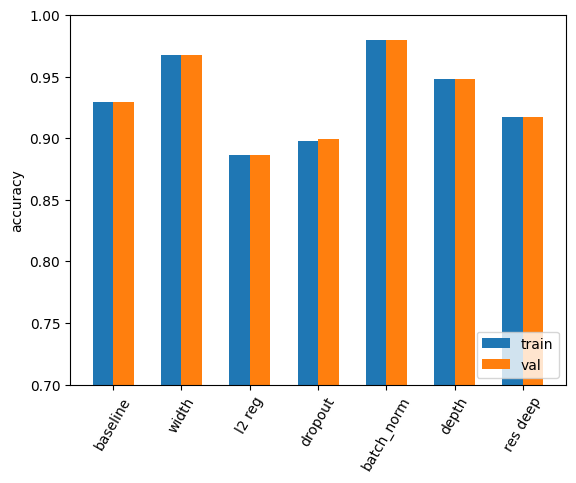

In [63]:
import numpy as np

trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()